In [102]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

In [103]:
data_path = './data/'
raw_train_df = pd.read_csv(data_path+'train.csv', index_col='PassengerId')
raw_test_df = pd.read_csv(data_path+'test.csv', index_col='PassengerId')

In [104]:
raw_train_df.describe(), raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


(         Survived      Pclass         Age       SibSp       Parch        Fare
 count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
 mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
 std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
 min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
 25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
 50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
 75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
 max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200,
 None)

In [105]:
columns_to_scale = ['Fare']
scaler = StandardScaler()

In [106]:
# Define a custom estimator to extract the deck information from the cabin column
class ExtractNthLetter(BaseEstimator, TransformerMixin):
    def __init__(self, column, n_letters=1):
        self.column = column
        self.n_letters = n_letters

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Deck"] = X[self.column].str[:self.n_letters]
        X.drop(columns=[self.column], inplace=True)
        return X

    def get_feature_names_out(self, input_features):
        return ["Deck"]

In [107]:
# Pipelines
deck_pipeline = Pipeline([
    ('deck_extract', ExtractNthLetter(column='Cabin')),
    ('deck_imputer', SimpleImputer(strategy="constant", fill_value="Missing Deck")),
    ('deck_onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

embarked_pipeline = Pipeline([
    ('embarked_imputer', SimpleImputer(strategy='most_frequent', copy=False)),
    ('embarked_onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

sex_pipeline = Pipeline([
    ('sex_encoder', OrdinalEncoder(categories=[['female', 'male']], encoded_missing_value=-1))
])

age_pipeline = Pipeline([
    ('age_imputer', KNNImputer(n_neighbors=5))
])

In [108]:
# Column Transformer
preprocessor = ColumnTransformer([
    ('standardise', scaler, columns_to_scale),                # Standardize numerical features
    ('deck', deck_pipeline, ['Cabin']),                       # Extract and encode deck info
    ('embarked', embarked_pipeline, ['Embarked']),            # One-hot-encode Embarked
    ('sex', sex_pipeline, ['Sex']),                           # Ordinal encode Sex
    ('age', age_pipeline, ['Age'])                            # Impute Age
], remainder='passthrough', verbose_feature_names_out=False)

In [109]:
# Preprocess the data
train_df = preprocessor.fit_transform(raw_train_df)

# Convert to DataFrame with column names
train_df = pd.DataFrame(
    train_df,
    index=raw_train_df.index,
    columns=preprocessor.get_feature_names_out()
).convert_dtypes()

In [110]:
train_df.drop(columns=['Name','Ticket'], inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Fare               891 non-null    Float64
 1   Deck_A             891 non-null    Int64  
 2   Deck_B             891 non-null    Int64  
 3   Deck_C             891 non-null    Int64  
 4   Deck_D             891 non-null    Int64  
 5   Deck_E             891 non-null    Int64  
 6   Deck_F             891 non-null    Int64  
 7   Deck_G             891 non-null    Int64  
 8   Deck_Missing Deck  891 non-null    Int64  
 9   Deck_T             891 non-null    Int64  
 10  Embarked_C         891 non-null    Int64  
 11  Embarked_Q         891 non-null    Int64  
 12  Embarked_S         891 non-null    Int64  
 13  Sex                891 non-null    Int64  
 14  Age                891 non-null    Float64
 15  Survived           891 non-null    Int64  
 16  Pclass             891 non-null

<Axes: >

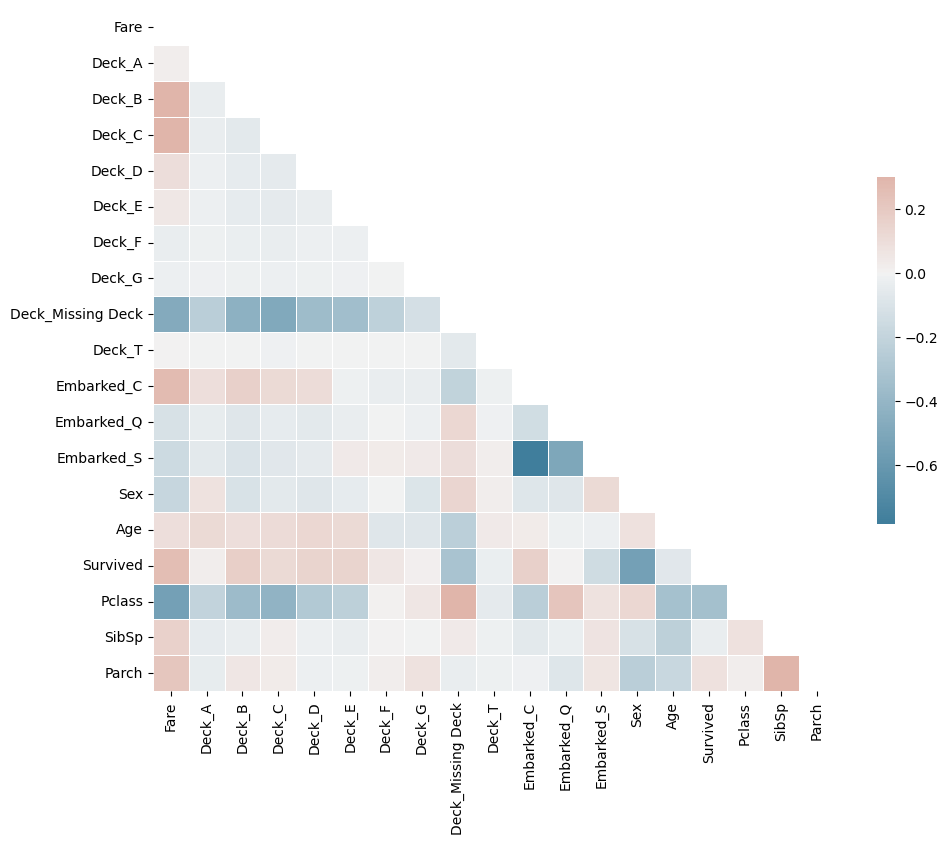

In [111]:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(corr,
            mask = mask,
            cmap = cmap,
            vmax = .3,
            center = 0,
            square = True,
            linewidths= .5,
            cbar_kws = {'shrink': .5}
            )

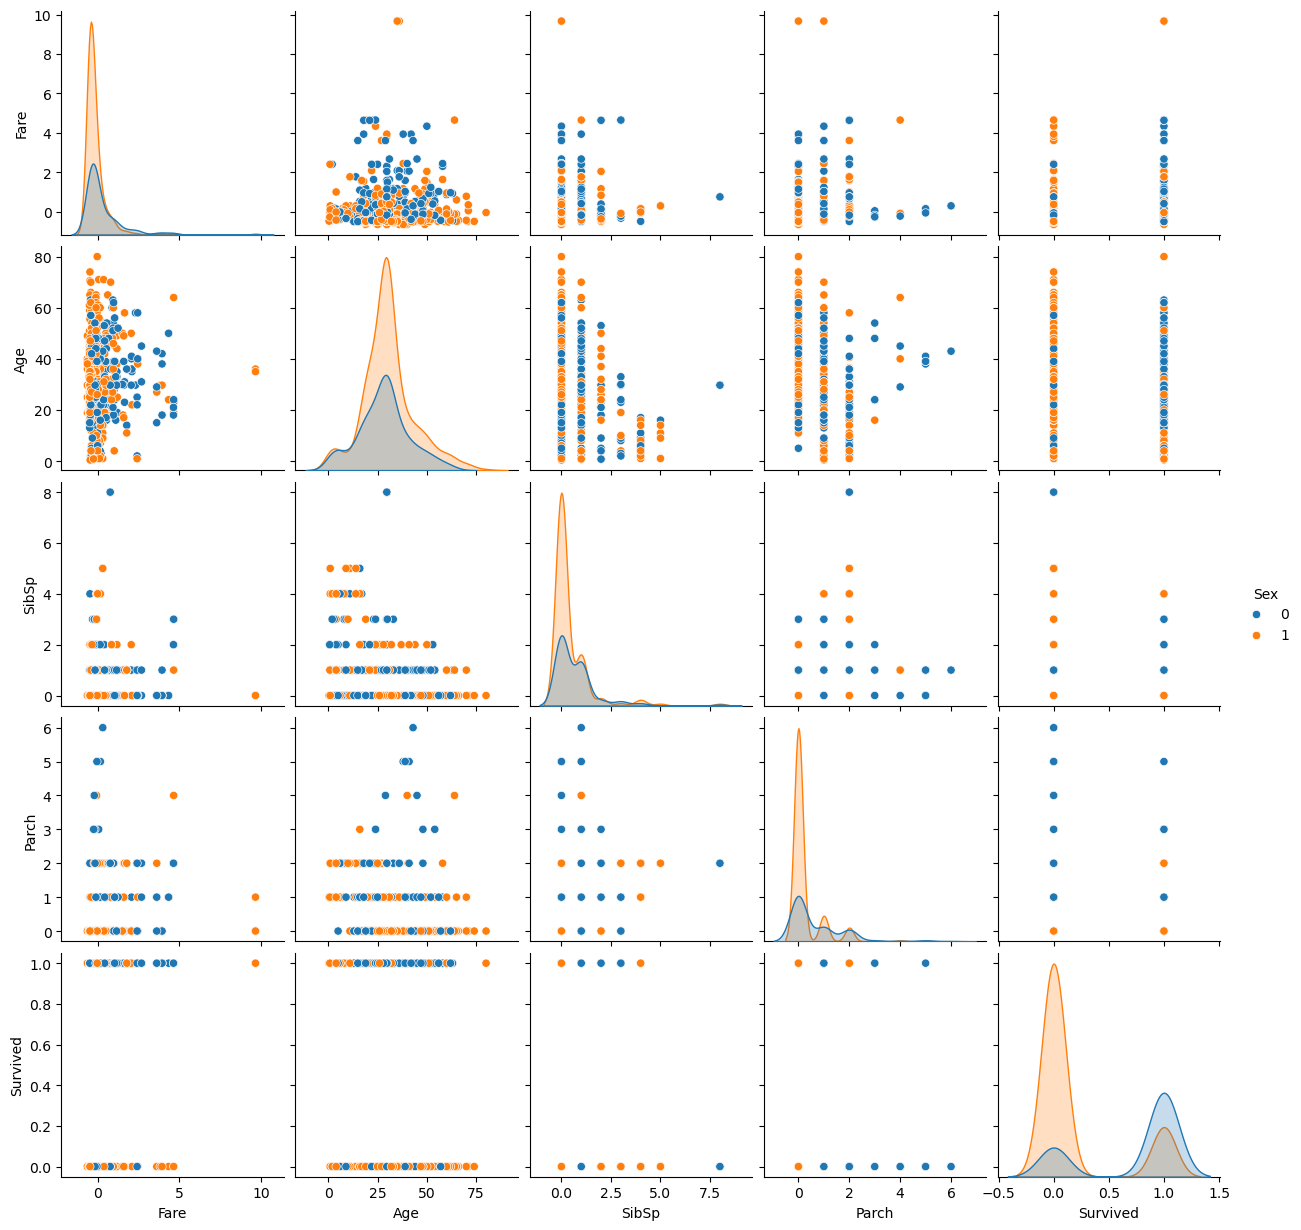

In [118]:
plot_columns = ['Fare', 'Sex', 'Age', 'SibSp', 'Parch','Survived']
sns.pairplot(train_df[plot_columns], hue='Sex')